# Finite Element Analysis
Prepared by Dr Dimitris Karamitros, Senior Lecturer in Geotechnical Engineering.  
Delivered as part of *CENG300010 - Advanced Structural Analysis* (University of Bristol, 2023).  
<br>
This notebook will be based on the simple case of rod elements that was implemented in previous weeks,  
and will now focus on the case of beams that can also undergo bending.  
<br>
*This is the full version, with comments and explanations.*

## Libraries
Finite Element Analysis requires basic linear algebra operations. The external library **numpy** will be imported to conduct these.  
It is also possible to use **scipy**, which offers additional functionality for integration, differential equations, eigenvalue problems and others.  
Nevertheless, **numpy** is sufficient for FEA.  
<br>
The **matplotlib.pyplot** library will also be imported to plot the obtained results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Pre-processing
First, we will define the structure to be analysed.

### Input Variables
Basic variables are initially defined.

In [2]:
E = 1
A = 10
I = 0.1
L = 1
F = 1

### Mesh Definition
To define the finite element mesh, we need a list of nodes, a list of elements connecting these nodes, properties for these elements, supports, and applied loads.

**Nodes** will be defined in terms of their coordinates **[x,y]**.  
We will define node numbers as 1,2,3,... We will deal with Python indexing later.

In [3]:
Nodes = np.array([
    [0,0],
    [L,0],
    [0,L],
    [L,L]])

In [4]:
# Count the number of nodes and degrees of freedom (DOFs):
nNodes = Nodes.shape[0]
nDOFs = 3*nNodes
print("Number of nodes = ",nNodes)
print("Number of DOFs = ",nDOFs)

Number of nodes =  4
Number of DOFs =  12


**Elements** will be defined in terms of starting and ending node.  
We will also assign a set of properties, from below.  
Therefore, for each element, we will have **[node1, node2, properties]**.

In [5]:
Elements = np.array([
    [1,3,1],
    [3,4,1],
    [4,2,1]])

In [6]:
# Count the number of elements:
nElements = Elements.shape[0]
print("Number of elements = ",nElements)

Number of elements =  3


For each set of element properties, **properties** will be defined following the convention **[E,A,I]**.  
Remember that this is a list of lists of properties, hence the two brackets.

In [7]:
Properties = np.array([
    [E,A,I]])

**Supports** (applied displacements) will be defined following the convention  
**[node, DOF (1 for x, 2 for y, 3 for rotation), displacement or rotation]**.

In [8]:
Supports = np.array([
    [1,1,0],
    [1,2,0],
    [1,3,0],
    [2,1,0],
    [2,2,0],
    [2,3,0]
    ])

In [9]:
# Count the number of supports:
nSupports = Supports.shape[0]
print("Number of supports = ",nSupports)

Number of supports =  6


**Loads** (applied forces) will be defined following the convention [node, direction (1 for x, 2 for y, 3 for rotation), load].  
Remember that *x* and *y* are positive towards the right and up, respectively.

In [10]:
Loads = np.array([
    [3,1,F]])

In [11]:
# Count the number of loads:
nLoads = Loads.shape[0]
print("Number of loads = ",nLoads)

Number of loads =  1


### Plot Mesh
We will plot the mesh to confirm that everything has been defined correctly.

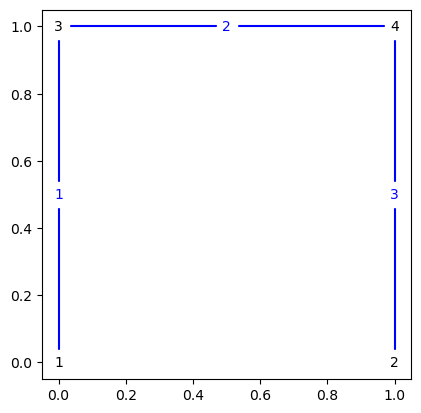

In [12]:
# Create empty figure and axes
fig1, ax1 = plt.subplots()
# Set apsect ratio x:y to 1:1
ax1.set_aspect(1)

# For each one of the elements
for iE,elem in enumerate(Elements):

    # Find Element Nodes
    node1 = elem[0]
    node2 = elem[1]
    
    # Find Node Coordinates
    # (we need to subtract 1 from node numbers, because we counted as 1,2,3,... while Python counts as 0,1,2,...)
    # (we use 0 for y and 1 for y directions)
    x1 = Nodes[node1-1,0]
    y1 = Nodes[node1-1,1]
    x2 = Nodes[node2-1,0]
    y2 = Nodes[node2-1,1]

    # Plot a Line
    ax1.plot([x1,x2],[y1,y2], color='blue')

    # Annotate the element number
    # (we need to add 1 because Python starts counting at 0)
    ax1.annotate(iE+1, xy=((x1+x2)/2,(y1+y2)/2), ha='center', va='center', color='blue', backgroundcolor='1')

# For each one of the nodes
for iN,node in enumerate(Nodes):

    # Find Node Coordinates
    x = node[0]
    y = node[1]

    # Annotate the node number
    # (we need to add 1 because Python starts counting at 0)
    ax1.annotate(iN+1, xy=(x,y), ha='center', va='center', color='black', backgroundcolor='1')

## Stiffness Matrix Assembly
First, define the **Global Stiffness Matrix K**. It should be square, with dimensions equal to *nDOFs x nDOFs*.

In [13]:
K = np.zeros((nDOFs,nDOFs))

Then, for each element, compute the **Element Stiffness Matrix ke**.  
For rod elements, in the *local coodrinate system*, the Element Stiffness Matrix is:
$$ [k_e] = \left[ \begin{array}{cccc}
    \frac{EA}{L} & 0 & 0 & -\frac{EA}{L} & 0 & 0 \\
    0 & \frac{12EI}{L^3} & \frac{6EI}{L^2} & 0 & -\frac{12EI}{L^3} & \frac{6EI}{L^2} \\
    0 & \frac{6EI}{L^2} & \frac{4EI}{L} & 0 & -\frac{6EI}{L^2} & \frac{2EI}{L} \\
    -\frac{EA}{L} & 0 & 0 & \frac{EA}{L} & 0 & 0 \\
    0 & -\frac{12EI}{L^3} & -\frac{6EI}{L^2} & 0 & \frac{12EI}{L^3} & -\frac{6EI}{L^2} \\
    0 & \frac{6EI}{L^2} & \frac{2EI}{L} & 0 & -\frac{6EI}{L^2} & \frac{4EI}{L} \\
    \end{array} \right] $$
The Element Stiffness Matrix in *global coordinates* is:
$$ [K_e] = [T]^T [k_e] [T] $$
where the *Coordinate Transform Matrix* is:
$$ [T] = \left[ \begin{array}{cccc} c&s&0&0&0&0 \\ -s&c&0&0&0&0 \\ 0&0&1&0&0&0 \\ 0&0&0&c&s&0 \\ 0&0&0&-s&c&0 \\ 0&0&0&0&0&1 \end{array} \right] $$

In [14]:
# For each one of the elements
for iE,elem in enumerate(Elements):

    # Find Element Nodes
    node1 = elem[0]
    node2 = elem[1]
    
    # Find Node Coordinates
    x1 = Nodes[node1-1,0]
    y1 = Nodes[node1-1,1]
    x2 = Nodes[node2-1,0]
    y2 = Nodes[node2-1,1]

    # Compute Element Stiffness Matrix in Local Coordinates
    prop = elem[2]
    E = Properties[prop-1,0]
    A = Properties[prop-1,1]
    I = Properties[prop-1,2]
    L = np.sqrt((x2-x1)**2+(y2-y1)**2)
    ke = np.array([
        [E*A/L, 0, 0, -E*A/L, 0, 0],
        [0, 12*E*I/L**3, 6*E*I/L**2, 0, -12*E*I/L**3, 6*E*I/L**2],
        [0, 6*E*I/L**2, 4*E*I/L, 0, -6*E*I/L**2, 2*E*I/L],
        [-E*A/L, 0, 0, E*A/L, 0, 0],
        [0, -12*E*I/L**3, -6*E*I/L**2, 0, 12*E*I/L**3, -6*E*I/L**2],
        [0, 6*E*I/L**2, 2*E*I/L, 0, -6*E*I/L**2, 4*E*I/L]])

    # Compute Coordinate Transformation Matrix
    theta = np.arctan2((y2-y1),(x2-x1))
    c = np.cos(theta)
    s = np.sin(theta)
    T = np.array([
        [c,s,0,0,0,0],
        [-s,c,0,0,0,0],
        [0,0,1,0,0,0],
        [0,0,0,c,s,0],
        [0,0,0,-s,c,0],
        [0,0,0,0,0,1]])
   
    # Compute Element Stiffness Matrix in Global Coordinates
    Ke = T.T @ ke @ T
    print("\nElement", iE+1, "Stiffness Matrix =")
    with np.printoptions(precision = 3, suppress = True):
        print(Ke)
    
    # Assemble Global Stiffness Matrix
    # Observe that for node = 1,2,3,... the expression 3*(node-1) gives 0,3,6,...
    # Similarly, for node = 1,2,3,... the expression 3*node gives 3,6,9,...    
    K[3*(node1-1):3*node1 , 3*(node1-1):3*node1] += Ke[0:3,0:3]
    K[3*(node1-1):3*node1 , 3*(node2-1):3*node2] += Ke[0:3,3:6]
    K[3*(node2-1):3*node2 , 3*(node1-1):3*node1] += Ke[3:6,0:3]
    K[3*(node2-1):3*node2 , 3*(node2-1):3*node2] += Ke[3:6,3:6]

# Print the final matrix
print("\nGlobal Stiffness Matrix =")
with np.printoptions(precision = 3, suppress = True):
    print(K)


Element 1 Stiffness Matrix =
[[  1.2   0.   -0.6  -1.2  -0.   -0.6]
 [  0.   10.    0.   -0.  -10.    0. ]
 [ -0.6   0.    0.4   0.6  -0.    0.2]
 [ -1.2  -0.    0.6   1.2   0.    0.6]
 [ -0.  -10.   -0.    0.   10.   -0. ]
 [ -0.6   0.    0.2   0.6  -0.    0.4]]

Element 2 Stiffness Matrix =
[[ 10.    0.    0.  -10.    0.    0. ]
 [  0.    1.2   0.6   0.   -1.2   0.6]
 [  0.    0.6   0.4   0.   -0.6   0.2]
 [-10.    0.    0.   10.    0.    0. ]
 [  0.   -1.2  -0.6   0.    1.2  -0.6]
 [  0.    0.6   0.2   0.   -0.6   0.4]]

Element 3 Stiffness Matrix =
[[  1.2  -0.    0.6  -1.2   0.    0.6]
 [ -0.   10.    0.    0.  -10.    0. ]
 [  0.6   0.    0.4  -0.6  -0.    0.2]
 [ -1.2   0.   -0.6   1.2  -0.   -0.6]
 [  0.  -10.   -0.   -0.   10.   -0. ]
 [  0.6   0.    0.2  -0.6  -0.    0.4]]

Global Stiffness Matrix =
[[  1.2   0.   -0.6   0.    0.    0.   -1.2  -0.   -0.6   0.    0.    0. ]
 [  0.   10.    0.    0.    0.    0.   -0.  -10.    0.    0.    0.    0. ]
 [ -0.6   0.    0.4   0.    

## Partitioning & Solution
To solve the problem, the stiffness matrix needs to be partitioned, based on known and unknown forces and displacements.

### Displacements
We will start from the **known displacements** $\{D_k\}$, defined earlier as supports.  
We will also define a vector with the corresponding degrees of freedom.

In [15]:
Dk = np.zeros(nSupports)
DkDOFs = np.zeros(nSupports,dtype=int)

# For each one of the supports:
for iS,support in enumerate(Supports):

    # Find the node number:
    node = support[0]

    # Find the support direction:
    xy = support[1]

    # Find the degree of freedom:
    dof = 3*(node-1) + (xy-1)

    # Append it to the known degrees of freedom vector:
    DkDOFs[iS] = dof

    # Find the applied displacement or rotation:
    disp = support[2]

    # Append it to the known displacements vector:
    Dk[iS] = disp

# Print the results
print("Known Displacements Dk = \n",Dk)
print("\nKnown Displacement DOFs =\n",DkDOFs)

Known Displacements Dk = 
 [0. 0. 0. 0. 0. 0.]

Known Displacement DOFs =
 [0 1 2 3 4 5]


### Loads
Similar to the above, we will generate a vector of **known forces** $\{Q_k\}$.  
We will also define a vector of the corresponding degrees of freedom.  
<br>
Note that there might be zero loads that have note been defined above.  
Therefore, we will first populate a vector with all the loads.  
Then, we will remove known-displacement DOFs and we will be left with known-force DOFs.  

In [16]:
# Start with all DOFs
QkDOFs = np.arange(nDOFs)
Qk = np.zeros(nDOFs)

# For each one of the loads:
for iL,load in enumerate(Loads):
    
    # Find the node number:
    node = load[0]

    # Find the load direction:
    xy = load[1]

    # Find the degree of freedom:
    dof = 3*(node-1) + (xy-1)

    # Find the applied force:
    force = load[2]

    # Append it to the known forces vector:
    Qk[dof] = force
    
# Remove DOFs with known displacements
QkDOFs = np.delete(QkDOFs,DkDOFs)
Qk = np.delete(Qk,DkDOFs)

# Print the results
print("Known Forces Qk = \n",Qk)
print("\nKnown Force DOFs =\n",QkDOFs)

Known Forces Qk = 
 [1. 0. 0. 0. 0. 0.]

Known Force DOFs =
 [ 6  7  8  9 10 11]


DOFs with known displacements have unknown forces and vice versa:

In [17]:
DuDOFs = QkDOFs
QuDOFs = DkDOFs

### Partitioning
Define the matrices $[K_{11}]$, $[K_{12}]$, $[K_{21}]$, and $[K_{22}]$.

In [18]:
K11 = K[np.ix_(QkDOFs,DuDOFs)]
K12 = K[np.ix_(QkDOFs,DkDOFs)]
K21 = K[np.ix_(QuDOFs,DuDOFs)]
K22 = K[np.ix_(QuDOFs,DkDOFs)]

# Print the results
np.set_printoptions(precision = 3, suppress = True)
print("K11 =\n",K11)
print("\nK12 =\n",K12)
print("\nK21 =\n",K21)
print("\nK22 =\n",K22)

K11 =
 [[ 11.2   0.    0.6 -10.    0.    0. ]
 [  0.   11.2   0.6   0.   -1.2   0.6]
 [  0.6   0.6   0.8   0.   -0.6   0.2]
 [-10.    0.    0.   11.2  -0.    0.6]
 [  0.   -1.2  -0.6  -0.   11.2  -0.6]
 [  0.    0.6   0.2   0.6  -0.6   0.8]]

K12 =
 [[ -1.2  -0.    0.6   0.    0.    0. ]
 [ -0.  -10.   -0.    0.    0.    0. ]
 [ -0.6   0.    0.2   0.    0.    0. ]
 [  0.    0.    0.   -1.2   0.    0.6]
 [  0.    0.    0.    0.  -10.    0. ]
 [  0.    0.    0.   -0.6  -0.    0.2]]

K21 =
 [[ -1.2  -0.   -0.6   0.    0.    0. ]
 [ -0.  -10.    0.    0.    0.    0. ]
 [  0.6  -0.    0.2   0.    0.    0. ]
 [  0.    0.    0.   -1.2   0.   -0.6]
 [  0.    0.    0.    0.  -10.   -0. ]
 [  0.    0.    0.    0.6   0.    0.2]]

K22 =
 [[ 1.2  0.  -0.6  0.   0.   0. ]
 [ 0.  10.   0.   0.   0.   0. ]
 [-0.6  0.   0.4  0.   0.   0. ]
 [ 0.   0.   0.   1.2 -0.  -0.6]
 [ 0.   0.   0.  -0.  10.  -0. ]
 [ 0.   0.   0.  -0.6 -0.   0.4]]


### Solution
First, solve this equation:
$$ \{D_u\} = [K_{11}]^{-1} (\{Q_k\} - [K_{12}]\{D_k\}) $$

In [19]:
Du = np.linalg.solve(K11, Qk - K12@Dk)
print("Computed displacements Du = \n",Du)

Computed displacements Du = 
 [ 0.655  0.041 -0.452  0.606 -0.041 -0.404]


Then, substitute into this equation:
$$ \{Q_u\} = [K_{21}]\{D_u\} + [K_{22}]\{D_k\} $$

In [20]:
Qu = K21@Du + K22@Dk
print("Computed reaction forces Qu =\n",Qu)

Computed reaction forces Qu =
 [-0.515 -0.414  0.303 -0.485  0.414  0.283]


### Combine Results
Combine the known and unknown displacements to get the **displacement vector**.

In [21]:
D = np.zeros(nDOFs)
D[DkDOFs] = Dk
D[DuDOFs] = Du
print("Displacement Vector D =\n",D)

Displacement Vector D =
 [ 0.     0.     0.     0.     0.     0.     0.655  0.041 -0.452  0.606
 -0.041 -0.404]


Combine the known and unknown forces to get the **force vector**.

In [22]:
Q = np.zeros(nDOFs)
Q[QkDOFs] = Qk
Q[QuDOFs] = Qu
print("Force Vector Q =\n",Q)

Force Vector Q =
 [-0.515 -0.414  0.303 -0.485  0.414  0.283  1.     0.     0.     0.
  0.     0.   ]


## Post-processing
Following the system solution, we will calculate element **axial forces**, **shear forces** and **bending moments**.

In [23]:
Axial = np.zeros(nElements)
Moment = np.zeros([nElements,2])
Shear = np.zeros(nElements)
    
# For each one of the elements:
for iE, elem in enumerate(Elements):
  
    # Find Element Nodes
    node1 = elem[0]
    node2 = elem[1]

    # Find node coordinates
    x1 = Nodes[node1-1,0]
    y1 = Nodes[node1-1,1]
    x2 = Nodes[node2-1,0]
    y2 = Nodes[node2-1,1]

    # Calculate coordinate transformation matrix
    theta = np.arctan2((y2-y1),(x2-x1))
    c = np.cos(theta)
    s = np.sin(theta)
    T = np.array([
        [c,s,0,0,0,0],
        [-s,c,0,0,0,0],
        [0,0,1,0,0,0],
        [0,0,0,c,s,0],
        [0,0,0,-s,c,0],
        [0,0,0,0,0,1]])
   
    # Find element displacements
    U = D[[
        3*(node1-1),
        3*(node1-1)+1,
        3*(node1-1)+2,
        3*(node2-1),
        3*(node2-1)+1,
        3*(node2-1)+2]]
    u = T@U

    # Find element properties
    prop = elem[2]
    E = Properties[prop-1,0]
    A = Properties[prop-1,1]
    I = Properties[prop-1,2]
    L = np.sqrt((x2-x1)**2+(y2-y1)**2)

    # Caclulate Element Axial Forces, Shear Forces and Bending Moments
    Naxial = np.array([-1/L,0,0,1/L,0,0])
    #Nmoment = np.array([0, -6/L**2+12*x/L**3, -4/L+6*x/L**2, 0, 6/L**2-12*x/L**3, -2/L+6*x/L**2])
    Nmoment = np.array([[0, -6/L**2, -4/L, 0, 6/L**2, -2/L],
        [0, 6/L**2, 2/L, 0, -6/L**2, 4/L]])
    Nshear = np.array([0, 12/L**3, 6/L**2, 0, -12/L**3, 6/L**2])
    # Caclulate Element Axial Forces, Shear Forces and Bending Moments
    Axial[iE] = E*A*Naxial@u
    Moment[iE,:] = E*I*Nmoment@u
    Shear[iE] = E*I*Nshear@u

# Print the results:
print("Element Axial Forces =\n",Axial)
print("\nElement Bending Moments (start/end) =\n",Moment)
print("\nElement Shear Forces =\n",Shear)

Element Axial Forces =
 [ 0.414 -0.485 -0.414]

Element Bending Moments (start/end) =
 [[-0.303  0.212]
 [ 0.212 -0.202]
 [-0.202  0.283]]

Element Shear Forces =
 [ 0.515 -0.414  0.485]


## Plot
This is similar to the plot above, but we will now add the **deformed mesh**.  
<br>
The displacements might be too small (or too large) and not show nicely in the plot.  
Therefore, we will multiply them by a **magnification factor**.

In [24]:
magFactor = 0.2

Now, let's proceed with the plot:

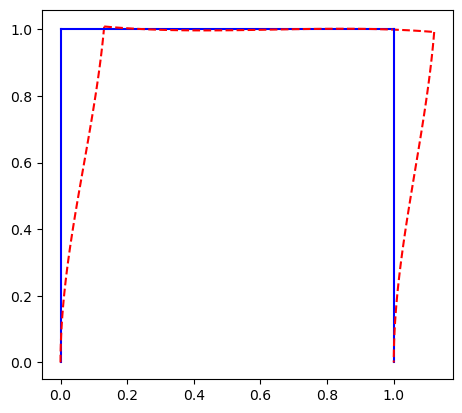

In [25]:
# Create a new figure and axes
fig2, ax2 = plt.subplots()
ax2.set_aspect(1)

# For each one of the elements
for iE,elem in enumerate(Elements):

    # Find Element Nodes
    node1 = elem[0]
    node2 = elem[1]
    
    # Find Node Coordinates
    x1 = Nodes[node1-1,0]
    y1 = Nodes[node1-1,1]
    x2 = Nodes[node2-1,0]
    y2 = Nodes[node2-1,1]

    # Create a line for the undeformed element
    L = np.sqrt((x2-x1)**2+(y2-y1)**2)
    l = np.linspace(0,L)
    xu = x1 + l*(x2-x1)
    yu = y1 + l*(y2-y1)

    # Find node displacements:
    U = D[[
        3*(node1-1),
        3*(node1-1)+1,
        3*(node1-1)+2,
        3*(node2-1),
        3*(node2-1)+1,
        3*(node2-1)+2]]

    # Calculate coordinate transformation matrix
    theta = np.arctan2((y2-y1),(x2-x1))
    c = np.cos(theta)
    s = np.sin(theta)
    T = np.array([
        [c,s,0,0,0,0],
        [-s,c,0,0,0,0],
        [0,0,1,0,0,0],
        [0,0,0,c,s,0],
        [0,0,0,-s,c,0],
        [0,0,0,0,0,1]])
    # For single point displacements (will be used later)
    t=np.array([[c,s],
        [-s,c]])

    # Transform displacements to local coordinates
    u = T@U

    # Define displacements along the beam element
    Ux = np.zeros([l.shape[0],2])
    for ix,x in enumerate(l):
        # Shape functions
        Nx = np.array([
            [1-x/L, 0, 0, x/L, 0, 0],
            [0, 1-3*x**2/L**2+2*x**3/L**3, x-2*x**2/L+x**3/L**2, 0, 3*x**2/L**2-2*x**3/L**3, -x**2/L+x**3/L**2]])
        # Displacements along the element in local coordinates
        ux = Nx@u
        # Displacements along the element in global coordinates
        Ux[ix,:] = t.T@ux

    # Final coordinates for the undeformed element
    xd = xu + magFactor*Ux[:,0]
    yd = yu + magFactor*Ux[:,1]

    # Plot a line for the undeformed element
    ax2.plot(xu,yu, color='blue')
    # Plot a line for the deformed element
    ax2.plot(xd,yd, color='red',linestyle='--')

You can add code to annotate nodes and elements.